# **Air Quality Forecasting Using Deep Learning**

## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

Num GPUs Available:  1
2.12.0


## Set up OpenAQ, Meteostat APIs

OpenAQ: https://openaq.org/
MeteoStat: https://meteostat.net/en


In [ ]:
pip install py-openaq

In [ ]:
import openaq
!pip install meteostat
from meteostat import Point, Hourly, Daily

openaq = openaq.OpenAQ(version="v2")

## Get data from OpenAQ

In [ ]:

class Location:
    def __init__(self, name, lat, lon):
        self.name = name
        self.lat = lat
        self.lon = lon


locations_IT = []

cities = openaq.cities(country="GB", limit=100000, df=True)["city"]

for city in cities:
    print(city) 
    try:
        res = openaq.locations(city=city, df=True)[["coordinates.latitude","coordinates.longitude"]].mean()
    
        locations_IT.append(Location(city, res["coordinates.latitude"], res["coordinates.longitude"]))
    except:
        print("-----------Skipped {}-----------".format(city))

In [ ]:
from datetime import datetime, timedelta
import time

selected_location = locations_IT[85]
print(selected_location.name)
# Format coordinates to align with OpenAQ standards
coordinates = "{},{}".format(round(selected_location.lat, 8), round(selected_location.lon, 8))

now = datetime(2021,10,1)

# OpenAQ API accepts the date only in this way
date_from = datetime(2020 , 5, 10)
date_to = datetime(now.year, now.month, now.day) + timedelta(days=1)

print("Time Range: {} - {}".format(date_from, date_to))

selected_pollutants = ['pm25','pm10','no2','o3','so2']

# Create empty Dataframe
df_pollutants = pd.DataFrame(columns=selected_pollutants)

# getPollutants()

for pollutant in selected_pollutants:
    locations = openaq.locations(coordinates=coordinates, parameter=pollutant, radius=20000, df=True, has_geo=True)

    dfs_array = []
    for location in locations["id"]:
        try:
            time.sleep(3)
            df = openaq.measurements(location=location,
                                     date_from=date_from.date(), 
                                     date_to=date_to.date(),
                                     limit=100000, 
                                     parameter=pollutant,
                                     df=True,
                                     sort="asc")[["value"]].resample('H').mean()
            
            dfs_array.append(df)
            print("Added location {}".format(location))
        
        except:
            print("Skipped location {}".format(location))
    
    dfs_array = sorted(dfs_array,key=lambda x:x.index[0])
    df_pollutants[pollutant] = pd.concat(dfs_array, join="outer", axis = 1, sort=False).mean(axis=1)
    print("Added pollutant {}".format(pollutant))
    print("---------------------")

print("Data fetching completed!")

df_pollutants

In [ ]:
loc = Point(selected_location.lat, selected_location.lon, 72)

# temp  The air temperature in °C
# dwpt  The dew point in °C
# rhum  The relative humidity in percent (%)
# prcp  The one hour precipitation total in mm
# snow  The snow depth in mm
# wdir  The average wind direction in degrees (°)
# wspd  The average wind speed in km/h
# wpgt  The peak wind gust in km/h
# pres  The average sea-level air pressure in hPa
# tsun  The one hour sunshine total in minutes (m)
# coco  The weather condition code

# Get hourly data
df_weather = Hourly(loc=loc, start=date_from, end=date_to)
df_weather = df_weather.normalize()
df_weather = df_weather.fetch()

# Remove columns that hold no values
weather_features = ['dwpt', 'prcp', 'snow', 'wdir', 'wpgt', 'tsun']
df_weather.drop(weather_features, axis=1, inplace=True)
final_df = df_pollutants.merge(df_weather, left_index=True, right_index=True)

final_df

### Data

In [ ]:
# final_df.to_csv('London.csv')
final_df=pd.read_csv('London.csv')
final_df

,Unnamed: 0,pm25,pm10,no2,o3,so2,co,temp,rhum,wspd,pres,coco
0,2020-05-10 01:00:00,17.472222,31.833333,31.625000,106.500000,4.333333,NaN,14.0,63.0,5.4,1007.0,3.0
1,2020-05-10 02:00:00,17.209714,32.500000,28.875000,105.666667,4.000000,NaN,14.0,63.0,5.4,1007.0,3.0
2,2020-05-10 03:00:00,17.487429,32.000000,30.250000,101.333333,5.500000,NaN,13.0,67.0,5.4,1007.0,3.0
3,2020-05-10 04:00:00,17.317647,31.250000,26.750000,98.333333,5.500000,NaN,13.0,72.0,3.6,1006.0,3.0
4,2020-05-10 05:00:00,18.183056,30.400000,24.000000,93.500000,4.666667,NaN,12.0,77.0,1.8,1007.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12235,2021-10-01 20:00:00,7.930435,16.167857,44.270886,29.529412,2.575000,450.0,13.0,63.0,13.0,1012.0,2.0
12236,2021-10-01 21:00:00,7.986957,15.759259,38.663636,30.725000,2.200000,400.0,12.0,67.0,14.8,1012.0,2.0
12237,2021-10-01 22:00:00,6.166667,15.637838,35.358333,30.737500,1.975000,350.0,11.0,71.0,9.4,1012.0,1.0
12238,2021-10-01 23:00:00,4.000000,11.166667,29.250000,37.000000,2.000000,NaN,11.0,71.0,7.6,1012.0,1.0


## **Preprocessing**
### 1. Remove column name 

In [ ]:
final_df=final_df.drop(['Unnamed: 0'], axis=1)
final_df

,pm25,pm10,no2,o3,so2,co,temp,rhum,wspd,pres,coco
0,17.472222,31.833333,31.625000,106.500000,4.333333,NaN,14.0,63.0,5.4,1007.0,3.0
1,17.209714,32.500000,28.875000,105.666667,4.000000,NaN,14.0,63.0,5.4,1007.0,3.0
2,17.487429,32.000000,30.250000,101.333333,5.500000,NaN,13.0,67.0,5.4,1007.0,3.0
3,17.317647,31.250000,26.750000,98.333333,5.500000,NaN,13.0,72.0,3.6,1006.0,3.0
4,18.183056,30.400000,24.000000,93.500000,4.666667,NaN,12.0,77.0,1.8,1007.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
12235,7.930435,16.167857,44.270886,29.529412,2.575000,450.0,13.0,63.0,13.0,1012.0,2.0
12236,7.986957,15.759259,38.663636,30.725000,2.200000,400.0,12.0,67.0,14.8,1012.0,2.0
12237,6.166667,15.637838,35.358333,30.737500,1.975000,350.0,11.0,71.0,9.4,1012.0,1.0
12238,4.000000,11.166667,29.250000,37.000000,2.000000,NaN,11.0,71.0,7.6,1012.0,1.0


### 2. Check missing values

In [ ]:
final_df.isnull().sum()

pm25    1157
pm10    1873
no2     1848
o3      1880
so2     1939
co      9593
temp       0
rhum       0
wspd       0
pres       0
coco       0
dtype: int64

In [ ]:
final_df['pm25'] = final_df['pm25'].fillna(final_df['pm25'].mean())
final_df['pm10'] = final_df['pm10'].fillna(final_df['pm10'].mean())
final_df['no2'] = final_df['no2'].fillna(final_df['no2'].mean())
final_df['o3'] = final_df['o3'].fillna(final_df['o3'].mean())
final_df['so2'] = final_df['so2'].fillna(final_df['so2'].mean())
final_df['co'] = final_df['co'].fillna(final_df['co'].mean())
final_df.isnull().sum()

pm25    0
pm10    0
no2     0
o3      0
so2     0
co      0
temp    0
rhum    0
wspd    0
pres    0
coco    0
dtype: int64

## **Standard ranges of Pollutants**

| Key | Category | PM2,5 μg/m³ | PM10 μg/m³ | NO2 ppb | O3 ppb | SO2 ppb
| :- | :- | :- | :- | :- | :- | :- |
| 1 | Good | 0-10 | 0-20 | 0-40 | 0-50 | 0-100 | 
| 2 | Fair | 10-20 | 20-40 | 40-90 | 50-100 | 100-200 | 
| 3 | Moderate | 20-25 | 40-50 | 90-120 | 100-130 | 200-350 | 
| 4 | Poor | 25-50 | 50-100 | 120-230 | 130-240 | 350-500 |
| 5 | Very Poor | 50-75 | 100-150 | 230-340 | 240-380 | 500-750 |
| 6 | Extremely Poor | 75-800 | 150-1200 | 340-1000 | 380-800 | 750-1250 |

We will use key numbers for each category:

Good: 1
Fair: 2
Moderate: 3
Poor: 4
Very Poor: 5
Extremely Poor: 6

### Assign category to values of pollutants w.r.t it's ranges

In [ ]:
def calcPM25(x):
    if x <= 10:
        return 1
    elif x >=11 and x <= 20:
        return 2
    elif x >=21 and x <= 25:
        return 3
    elif x >=26 and x <= 50:
        return 4
    elif x >=51 and x <= 75:
        return 5
    elif x >=76:
        return 6
    else:
        return 1
    
def calcPM10(x):
    if x <= 20:
        return 1
    elif x >=21 and x <= 40:
        return 2
    elif x >=41 and x <= 50:
        return 3
    elif x >=51 and x <= 100:
        return 4
    elif x >=101 and x <= 150:
        return 5
    elif x >=151:
        return 6
    else:
        return 1
    
def calcNO2(x):
    if x <= 40:
        return 1
    elif x >=41 and x <= 90:
        return 2
    elif x >=91 and x <= 120:
        return 3
    elif x >=121 and x <= 230:
        return 4
    elif x >=231 and x <= 340:
        return 5
    elif x >=341:
        return 6
    else:
        return 1
    
def calcO3(x):
    if x <= 50:
        return 1
    elif x >=51 and x <= 100:
        return 2
    elif x >=101 and x <= 130:
        return 3
    elif x >=131 and x <= 240:
        return 4
    elif x >=241 and x <= 380:
        return 5
    elif x >=381:
        return 6
    else:
        return 1
    
def calcSO2(x):
    if x <= 100:
        return 1
    elif x >=101 and x <= 200:
        return 2
    elif x >=201 and x <= 350:
        return 3
    elif x >=351 and x <= 500:
        return 4
    elif x >=501 and x <= 750:
        return 5
    elif x >=751:
        return 6
    else:
        return 1
    

    
final_df["pm25_AQI"] = final_df["pm25"].apply(lambda x: calcPM25(x))
final_df["pm10_AQI"] = final_df["pm10"].apply(lambda x: calcPM10(x))
final_df["no2_AQI"] = final_df["no2"].apply(lambda x: calcNO2(x))
final_df["o3_AQI"] = final_df["o3"].apply(lambda x: calcO3(x))
final_df["so2_AQI"] = final_df["so2"].apply(lambda x: calcSO2(x))

### AQI : https://edition.cnn.com/2019/10/25/world/copernicus-air-quality-index/index.html

### The overall hourly European Air Quality index is simply defined as the highest value of the 5 individual pollutants indexes computed for the same hour. For instance, if the indices relative to PM2.5, PM10, No2, O3, So2 are 2,2,1,3,1 respectively, the overall index will be 3.

In [ ]:
final_df["overall_AQI"] = final_df[["pm25_AQI","pm10_AQI","no2_AQI","o3_AQI","so2_AQI"]].max(axis=1)

final_df

,pm25,pm10,no2,o3,so2,co,temp,rhum,wspd,pres,coco,pm25_AQI,pm10_AQI,no2_AQI,o3_AQI,so2_AQI,overall_AQI
0,17.472222,31.833333,31.625000,106.500000,4.333333,359.29354,14.0,63.0,5.4,1007.0,3.0,2,2,1,3,1,3
1,17.209714,32.500000,28.875000,105.666667,4.000000,359.29354,14.0,63.0,5.4,1007.0,3.0,2,2,1,3,1,3
2,17.487429,32.000000,30.250000,101.333333,5.500000,359.29354,13.0,67.0,5.4,1007.0,3.0,2,2,1,3,1,3
3,17.317647,31.250000,26.750000,98.333333,5.500000,359.29354,13.0,72.0,3.6,1006.0,3.0,2,2,1,2,1,2
4,18.183056,30.400000,24.000000,93.500000,4.666667,359.29354,12.0,77.0,1.8,1007.0,3.0,2,2,1,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12235,7.930435,16.167857,44.270886,29.529412,2.575000,450.00000,13.0,63.0,13.0,1012.0,2.0,1,1,2,1,1,2
12236,7.986957,15.759259,38.663636,30.725000,2.200000,400.00000,12.0,67.0,14.8,1012.0,2.0,1,1,1,1,1,1
12237,6.166667,15.637838,35.358333,30.737500,1.975000,350.00000,11.0,71.0,9.4,1012.0,1.0,1,1,1,1,1,1
12238,4.000000,11.166667,29.250000,37.000000,2.000000,359.29354,11.0,71.0,7.6,1012.0,1.0,1,1,1,1,1,1


### Change type of each value for memory performance

In [ ]:
final_df = final_df.astype(np.float32)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12240 entries, 0 to 12239
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pm25         12240 non-null  float32
 1   pm10         12240 non-null  float32
 2   no2          12240 non-null  float32
 3   o3           12240 non-null  float32
 4   so2          12240 non-null  float32
 5   co           12240 non-null  float32
 6   temp         12240 non-null  float32
 7   rhum         12240 non-null  float32
 8   wspd         12240 non-null  float32
 9   pres         12240 non-null  float32
 10  coco         12240 non-null  float32
 11  pm25_AQI     12240 non-null  float32
 12  pm10_AQI     12240 non-null  float32
 13  no2_AQI      12240 non-null  float32
 14  o3_AQI       12240 non-null  float32
 15  so2_AQI      12240 non-null  float32
 16  overall_AQI  12240 non-null  float32
dtypes: float32(17)
memory usage: 812.9 KB


# Data Correlation

### Pearson's Correlation 


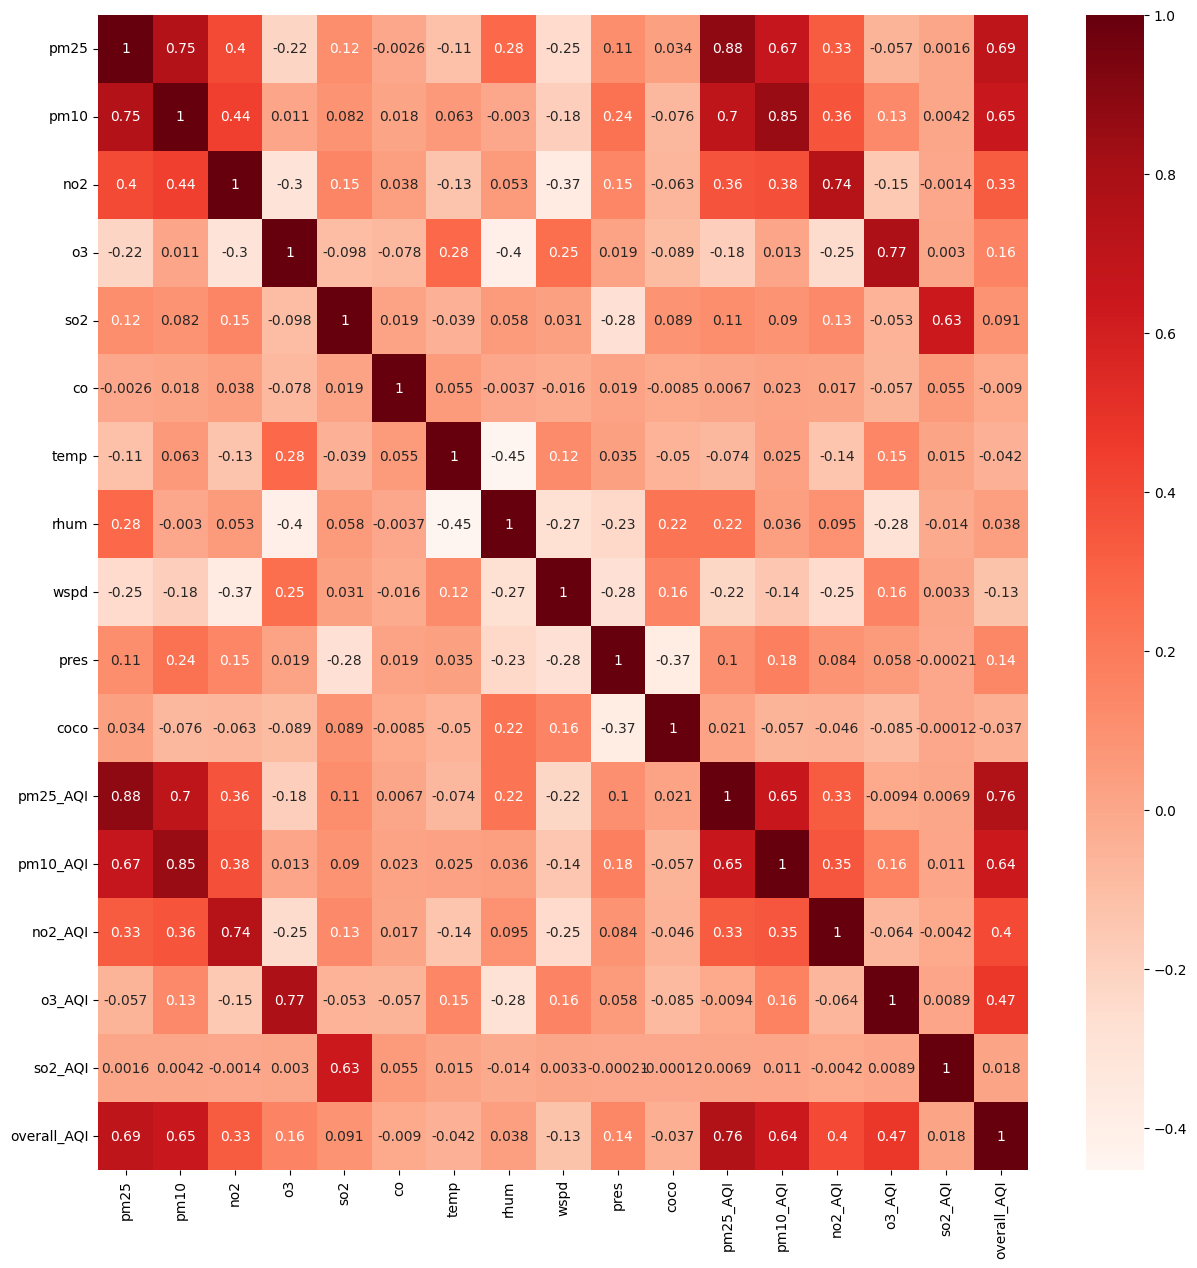

In [ ]:
plt.figure(figsize=(15,15))
cor = final_df.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# Data Preparation Models

In [ ]:
final_df.columns

Index(['pm25', 'pm10', 'no2', 'o3', 'so2', 'co', 'temp', 'rhum', 'wspd',
       'pres', 'coco', 'pm25_AQI', 'pm10_AQI', 'no2_AQI', 'o3_AQI', 'so2_AQI',
       'overall_AQI'],
      dtype='object')

In [ ]:
dataset = final_df.copy()
dataset

,pm25,pm10,no2,o3,so2,co,temp,rhum,wspd,pres,coco,pm25_AQI,pm10_AQI,no2_AQI,o3_AQI,so2_AQI,overall_AQI
0,17.472221,31.833334,31.625000,106.500000,4.333333,359.293549,14.0,63.0,5.4,1007.0,3.0,2.0,2.0,1.0,3.0,1.0,3.0
1,17.209715,32.500000,28.875000,105.666664,4.000000,359.293549,14.0,63.0,5.4,1007.0,3.0,2.0,2.0,1.0,3.0,1.0,3.0
2,17.487429,32.000000,30.250000,101.333336,5.500000,359.293549,13.0,67.0,5.4,1007.0,3.0,2.0,2.0,1.0,3.0,1.0,3.0
3,17.317648,31.250000,26.750000,98.333336,5.500000,359.293549,13.0,72.0,3.6,1006.0,3.0,2.0,2.0,1.0,2.0,1.0,2.0
4,18.183056,30.400000,24.000000,93.500000,4.666667,359.293549,12.0,77.0,1.8,1007.0,3.0,2.0,2.0,1.0,2.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12235,7.930435,16.167856,44.270885,29.529411,2.575000,450.000000,13.0,63.0,13.0,1012.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0
12236,7.986957,15.759259,38.663635,30.725000,2.200000,400.000000,12.0,67.0,14.8,1012.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
12237,6.166667,15.637837,35.358334,30.737499,1.975000,350.000000,11.0,71.0,9.4,1012.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
12238,4.000000,11.166667,29.250000,37.000000,2.000000,359.293549,11.0,71.0,7.6,1012.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# Splitting Data

In [ ]:
from sklearn.model_selection import train_test_split

features=dataset.values
targets=dataset[["pm25", "pm10", "no2", "o3", "so2"]].values

X_train, X_test, y_train, y_test  = train_test_split(features, targets, test_size=0.1, random_state=1, shuffle=False)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.1, random_state=1, shuffle=False)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

X_train: (9914, 17)
X_test: (1224, 17)


# Data Normalizaton

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_val = scaler.transform(X_val)

X_test = scaler.transform(X_test)

X_train.shape, X_test.shape

((9914, 17), (1224, 17))

# Set up data with TimeseriesGenerator

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

win_length=12
batch_size=4
num_features=features.shape[1]

train_generator = TimeseriesGenerator(X_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

train_generator[0]

(array([[[0.15462504, 0.3703704 , 0.29790503, 0.6818182 , 0.03880597,
          0.3266305 , 0.45      , 0.55421686, 0.108     , 0.5070429 ,
          0.08      , 0.2       , 0.33333334, 0.        , 0.6666666 ,
          0.        , 0.40000004],
         [0.151932  , 0.37908497, 0.2702514 , 0.67648315, 0.0358209 ,
          0.3266305 , 0.45      , 0.55421686, 0.108     , 0.5070429 ,
          0.08      , 0.2       , 0.33333334, 0.        , 0.6666666 ,
          0.        , 0.40000004],
         [0.15478106, 0.37254903, 0.2840782 , 0.64874095, 0.04925374,
          0.3266305 , 0.425     , 0.6024096 , 0.108     , 0.5070429 ,
          0.08      , 0.2       , 0.33333334, 0.        , 0.6666666 ,
          0.        , 0.40000004],
         [0.15303929, 0.3627451 , 0.24888268, 0.6295348 , 0.04925374,
          0.3266305 , 0.425     , 0.6626506 , 0.072     , 0.49295807,
          0.08      , 0.2       , 0.33333334, 0.        , 0.33333334,
          0.        , 0.2       ],
         [0.16191746

# Bi-LSTM Model

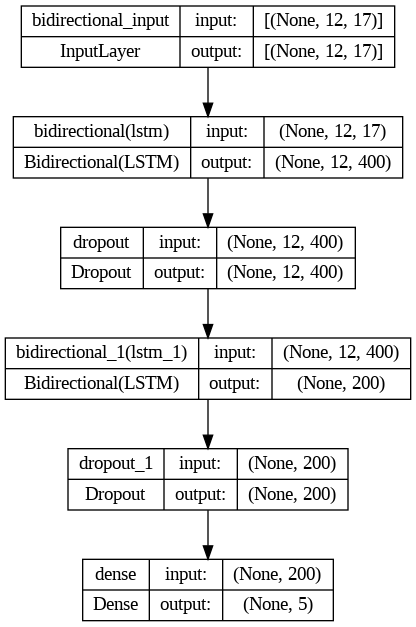

In [ ]:
model_LSTM = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200,  return_sequences=True), input_shape=(win_length, num_features)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=False)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(targets.shape[1])
])

model_LSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.losses.MeanSquaredLogarithmicError())

# MeanSquaredLogarithmicError, normalize outliers in specific range
tf.keras.utils.plot_model(model=model_LSTM, show_shapes=True)

#Fit Model

In [ ]:
lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, cooldown=1)
# reduce LR when metrics gets stop and training get stop
# suffle false , dont split data randomly
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

with tf.device('/GPU:0'):
    prepared_model = model_LSTM.fit(train_generator, 
                                    validation_data=val_generator,
                                    epochs=30, 
                                    shuffle=False,  
                                    callbacks=[lr_monitor, early_stopping])

Epoch 1/30
2476/2476 [==============================] - 43s 12ms/step - loss: 0.2590 - val_loss: 0.1328 - lr: 0.0010
Epoch 2/30
2476/2476 [==============================] - 31s 13ms/step - loss: 0.2151 - val_loss: 0.1319 - lr: 0.0010
Epoch 3/30
2476/2476 [==============================] - 35s 14ms/step - loss: 0.2037 - val_loss: 0.1059 - lr: 0.0010
Epoch 4/30
2476/2476 [==============================] - 28s 11ms/step - loss: 0.1643 - val_loss: 0.0996 - lr: 0.0010
Epoch 5/30
2476/2476 [==============================] - 32s 13ms/step - loss: 0.1463 - val_loss: 0.0895 - lr: 0.0010
Epoch 6/30
2476/2476 [==============================] - 29s 12ms/step - loss: 0.1338 - val_loss: 0.0729 - lr: 0.0010
Epoch 7/30
2476/2476 [==============================] - 27s 11ms/step - loss: 0.1163 - val_loss: 0.0617 - lr: 0.0010
Epoch 8/30
2476/2476 [==============================] - 28s 11ms/step - loss: 0.1029 - val_loss: 0.0549 - lr: 0.0010
Epoch 9/30
2476/2476 [==============================] - 30s 12ms

# Training V/S Validation Loss

Text(0, 0.5, 'msle score')

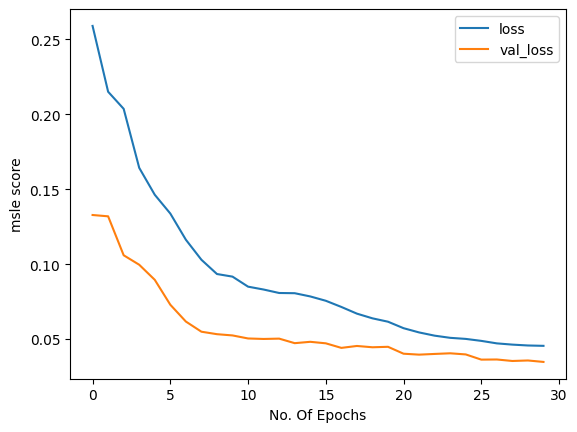

In [ ]:
plt.plot(prepared_model.history["loss"],label="loss")
plt.plot(prepared_model.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("msle score")

In [ ]:
model_LSTM.evaluate(test_generator, verbose=1)

303/303 [==============================] - 1s 5ms/step - loss: 0.0325


0.03246232122182846

# Predictions values by model

In [ ]:
predictions=model_LSTM.predict(test_generator)

pd.DataFrame(predictions)

303/303 [==============================] - 3s 4ms/step


,0,1,2,3,4
0,5.753057,11.649464,21.294561,28.565632,2.920720
1,6.558636,13.434666,20.025555,29.041843,2.945588
2,6.789258,13.752567,19.488310,30.175423,3.306788
3,5.904471,12.933575,19.777409,31.027082,2.872153
4,5.799753,12.566877,19.497427,31.313103,2.520612
...,...,...,...,...,...
1207,6.215326,12.980289,41.446259,36.356777,3.219406
1208,7.516627,15.200112,40.798275,33.998730,3.376822
1209,7.563564,16.040955,34.552170,31.863274,2.981016
1210,6.805031,14.938324,32.683792,31.172218,2.550005


In [ ]:
df_pred=pd.DataFrame(X_test[:,:][win_length:])

rev_trans=scaler.inverse_transform(df_pred)

df_final=dataset[rev_trans.shape[0]*-1:]
df_final

,pm25,pm10,no2,o3,so2,co,temp,rhum,wspd,pres,coco,pm25_AQI,pm10_AQI,no2_AQI,o3_AQI,so2_AQI,overall_AQI
11028,6.330435,14.375439,21.420000,27.362499,2.725000,500.000000,21.0,73.0,18.4,1018.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0
11029,6.617391,13.792982,20.632500,28.937500,3.333333,450.000000,21.0,73.0,20.5,1018.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0
11030,5.734783,12.836843,20.650000,29.412500,2.650000,450.000000,22.0,65.0,20.5,1018.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0
11031,5.813044,12.135715,20.601250,30.531250,2.250000,500.000000,21.0,69.0,20.5,1018.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0
11032,5.756522,11.617857,18.305063,31.906250,3.200000,500.000000,21.0,69.0,14.8,1018.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12235,7.930435,16.167856,44.270885,29.529411,2.575000,450.000000,13.0,63.0,13.0,1012.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0
12236,7.986957,15.759259,38.663635,30.725000,2.200000,400.000000,12.0,67.0,14.8,1012.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
12237,6.166667,15.637837,35.358334,30.737499,1.975000,350.000000,11.0,71.0,9.4,1012.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
12238,4.000000,11.166667,29.250000,37.000000,2.000000,359.293549,11.0,71.0,7.6,1012.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
df_final[["pm25_pred", "pm10_pred", "no2_pred", "o3_pred", "so2_pred"]]=predictions
df_final

<ipython-input-27-5ec2f62f62d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[["pm25_pred", "pm10_pred", "no2_pred", "o3_pred", "so2_pred"]]=predictions
<ipython-input-27-5ec2f62f62d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[["pm25_pred", "pm10_pred", "no2_pred", "o3_pred", "so2_pred"]]=predictions
<ipython-input-27-5ec2f62f62d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,pm25,pm10,no2,o3,so2,co,temp,rhum,wspd,pres,...,pm10_AQI,no2_AQI,o3_AQI,so2_AQI,overall_AQI,pm25_pred,pm10_pred,no2_pred,o3_pred,so2_pred
11028,6.330435,14.375439,21.420000,27.362499,2.725000,500.000000,21.0,73.0,18.4,1018.0,...,1.0,1.0,1.0,1.0,1.0,5.753057,11.649464,21.294561,28.565632,2.920720
11029,6.617391,13.792982,20.632500,28.937500,3.333333,450.000000,21.0,73.0,20.5,1018.0,...,1.0,1.0,1.0,1.0,1.0,6.558636,13.434666,20.025555,29.041843,2.945588
11030,5.734783,12.836843,20.650000,29.412500,2.650000,450.000000,22.0,65.0,20.5,1018.0,...,1.0,1.0,1.0,1.0,1.0,6.789258,13.752567,19.488310,30.175423,3.306788
11031,5.813044,12.135715,20.601250,30.531250,2.250000,500.000000,21.0,69.0,20.5,1018.0,...,1.0,1.0,1.0,1.0,1.0,5.904471,12.933575,19.777409,31.027082,2.872153
11032,5.756522,11.617857,18.305063,31.906250,3.200000,500.000000,21.0,69.0,14.8,1018.0,...,1.0,1.0,1.0,1.0,1.0,5.799753,12.566877,19.497427,31.313103,2.520612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12235,7.930435,16.167856,44.270885,29.529411,2.575000,450.000000,13.0,63.0,13.0,1012.0,...,1.0,2.0,1.0,1.0,2.0,6.215326,12.980289,41.446259,36.356777,3.219406
12236,7.986957,15.759259,38.663635,30.725000,2.200000,400.000000,12.0,67.0,14.8,1012.0,...,1.0,1.0,1.0,1.0,1.0,7.516627,15.200112,40.798275,33.998730,3.376822
12237,6.166667,15.637837,35.358334,30.737499,1.975000,350.000000,11.0,71.0,9.4,1012.0,...,1.0,1.0,1.0,1.0,1.0,7.563564,16.040955,34.552170,31.863274,2.981016
12238,4.000000,11.166667,29.250000,37.000000,2.000000,359.293549,11.0,71.0,7.6,1012.0,...,1.0,1.0,1.0,1.0,1.0,6.805031,14.938324,32.683792,31.172218,2.550005


## Categories new predicted values in respective category

In [ ]:
def calcPM25(x):
    if x <= 10:
        return 1
    elif x >=11 and x <= 20:
        return 2
    elif x >=21 and x <= 25:
        return 3
    elif x >=26 and x <= 50:
        return 4
    elif x >=51 and x <= 75:
        return 5
    elif x >=76:
        return 6
    else:
        return 1
    
def calcPM10(x):
    if x <= 20:
        return 1
    elif x >=21 and x <= 40:
        return 2
    elif x >=41 and x <= 50:
        return 3
    elif x >=51 and x <= 100:
        return 4
    elif x >=101 and x <= 150:
        return 5
    elif x >=151:
        return 6
    else:
        return 1
    
def calcNO2(x):
    if x <= 40:
        return 1
    elif x >=41 and x <= 90:
        return 2
    elif x >=91 and x <= 120:
        return 3
    elif x >=121 and x <= 230:
        return 4
    elif x >=231 and x <= 340:
        return 5
    elif x >=341:
        return 6
    else:
        return 1
    
def calcO3(x):
    if x <= 50:
        return 1
    elif x >=51 and x <= 100:
        return 2
    elif x >=101 and x <= 130:
        return 3
    elif x >=131 and x <= 240:
        return 4
    elif x >=241 and x <= 380:
        return 5
    elif x >=381:
        return 6
    else:
        return 1
    
def calcSO2(x):
    if x <= 100:
        return 1
    elif x >=101 and x <= 200:
        return 2
    elif x >=201 and x <= 350:
        return 3
    elif x >=351 and x <= 500:
        return 4
    elif x >=501 and x <= 750:
        return 5
    elif x >=751:
        return 6
    else:
        return 1
    

    
df_final["pm25_AQI_pred"] = df_final["pm25_pred"].apply(lambda x: calcPM25(x))
df_final["pm10_AQI_pred"] = df_final["pm10_pred"].apply(lambda x: calcPM10(x))
df_final["no2_AQI_pred"] = df_final["no2_pred"].apply(lambda x: calcNO2(x))
df_final["o3_AQI_pred"] = df_final["o3_pred"].apply(lambda x: calcO3(x))
df_final["so2_AQI_pred"] = df_final["so2_pred"].apply(lambda x: calcSO2(x))

<ipython-input-28-fd727cc792f7>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["pm25_AQI_pred"] = df_final["pm25_pred"].apply(lambda x: calcPM25(x))
<ipython-input-28-fd727cc792f7>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["pm10_AQI_pred"] = df_final["pm10_pred"].apply(lambda x: calcPM10(x))
<ipython-input-28-fd727cc792f7>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [ ]:
df_final["overall_pred_aqi"] = df_final[["pm25_AQI_pred","pm10_AQI_pred","no2_AQI_pred","o3_AQI_pred","so2_AQI_pred"]].max(axis=1)

df_final

<ipython-input-29-d7723ddbf5fb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["overall_pred_aqi"] = df_final[["pm25_AQI_pred","pm10_AQI_pred","no2_AQI_pred","o3_AQI_pred","so2_AQI_pred"]].max(axis=1)


,pm25,pm10,no2,o3,so2,co,temp,rhum,wspd,pres,...,pm10_pred,no2_pred,o3_pred,so2_pred,pm25_AQI_pred,pm10_AQI_pred,no2_AQI_pred,o3_AQI_pred,so2_AQI_pred,overall_pred_aqi
11028,6.330435,14.375439,21.420000,27.362499,2.725000,500.000000,21.0,73.0,18.4,1018.0,...,11.649464,21.294561,28.565632,2.920720,1,1,1,1,1,1
11029,6.617391,13.792982,20.632500,28.937500,3.333333,450.000000,21.0,73.0,20.5,1018.0,...,13.434666,20.025555,29.041843,2.945588,1,1,1,1,1,1
11030,5.734783,12.836843,20.650000,29.412500,2.650000,450.000000,22.0,65.0,20.5,1018.0,...,13.752567,19.488310,30.175423,3.306788,1,1,1,1,1,1
11031,5.813044,12.135715,20.601250,30.531250,2.250000,500.000000,21.0,69.0,20.5,1018.0,...,12.933575,19.777409,31.027082,2.872153,1,1,1,1,1,1
11032,5.756522,11.617857,18.305063,31.906250,3.200000,500.000000,21.0,69.0,14.8,1018.0,...,12.566877,19.497427,31.313103,2.520612,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12235,7.930435,16.167856,44.270885,29.529411,2.575000,450.000000,13.0,63.0,13.0,1012.0,...,12.980289,41.446259,36.356777,3.219406,1,1,2,1,1,2
12236,7.986957,15.759259,38.663635,30.725000,2.200000,400.000000,12.0,67.0,14.8,1012.0,...,15.200112,40.798275,33.998730,3.376822,1,1,1,1,1,1
12237,6.166667,15.637837,35.358334,30.737499,1.975000,350.000000,11.0,71.0,9.4,1012.0,...,16.040955,34.552170,31.863274,2.981016,1,1,1,1,1,1
12238,4.000000,11.166667,29.250000,37.000000,2.000000,359.293549,11.0,71.0,7.6,1012.0,...,14.938324,32.683792,31.172218,2.550005,1,1,1,1,1,1


# Accuracy Prediction

In [ ]:
from sklearn.metrics import accuracy_score

overall_AQI = df_final["overall_AQI"].values
overall_pred_aqi = df_final["overall_pred_aqi"].values

accuracy = accuracy_score(overall_AQI, overall_pred_aqi)

print(accuracy)

0.8341584158415841


# Visualization of actual and predicted values by  model

<Axes: >

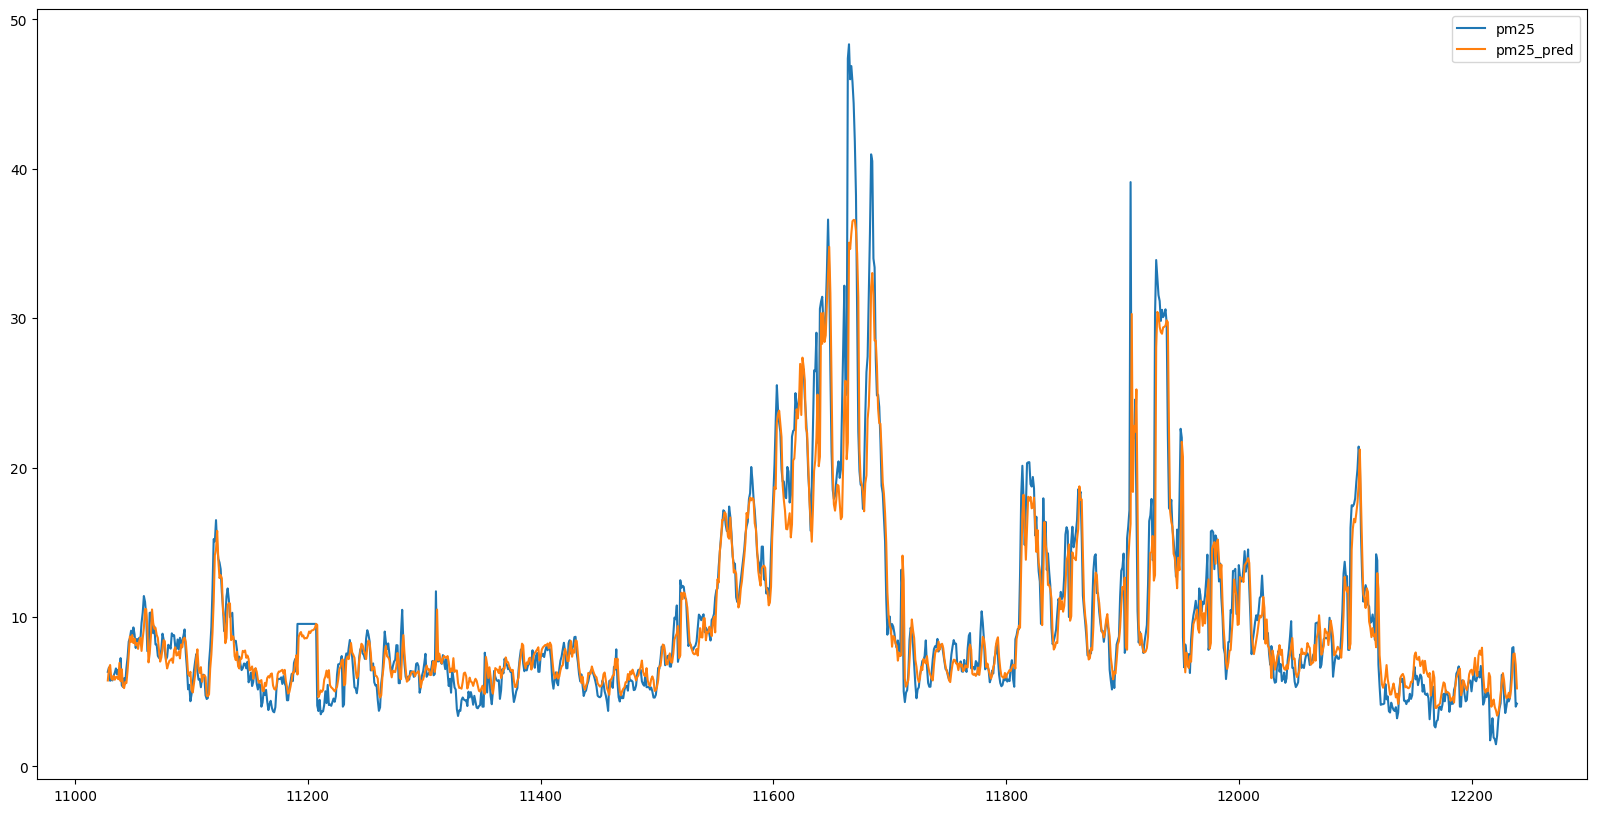

In [ ]:
df_final[["pm25","pm25_pred"]].plot(figsize=(20,10))

<Axes: >

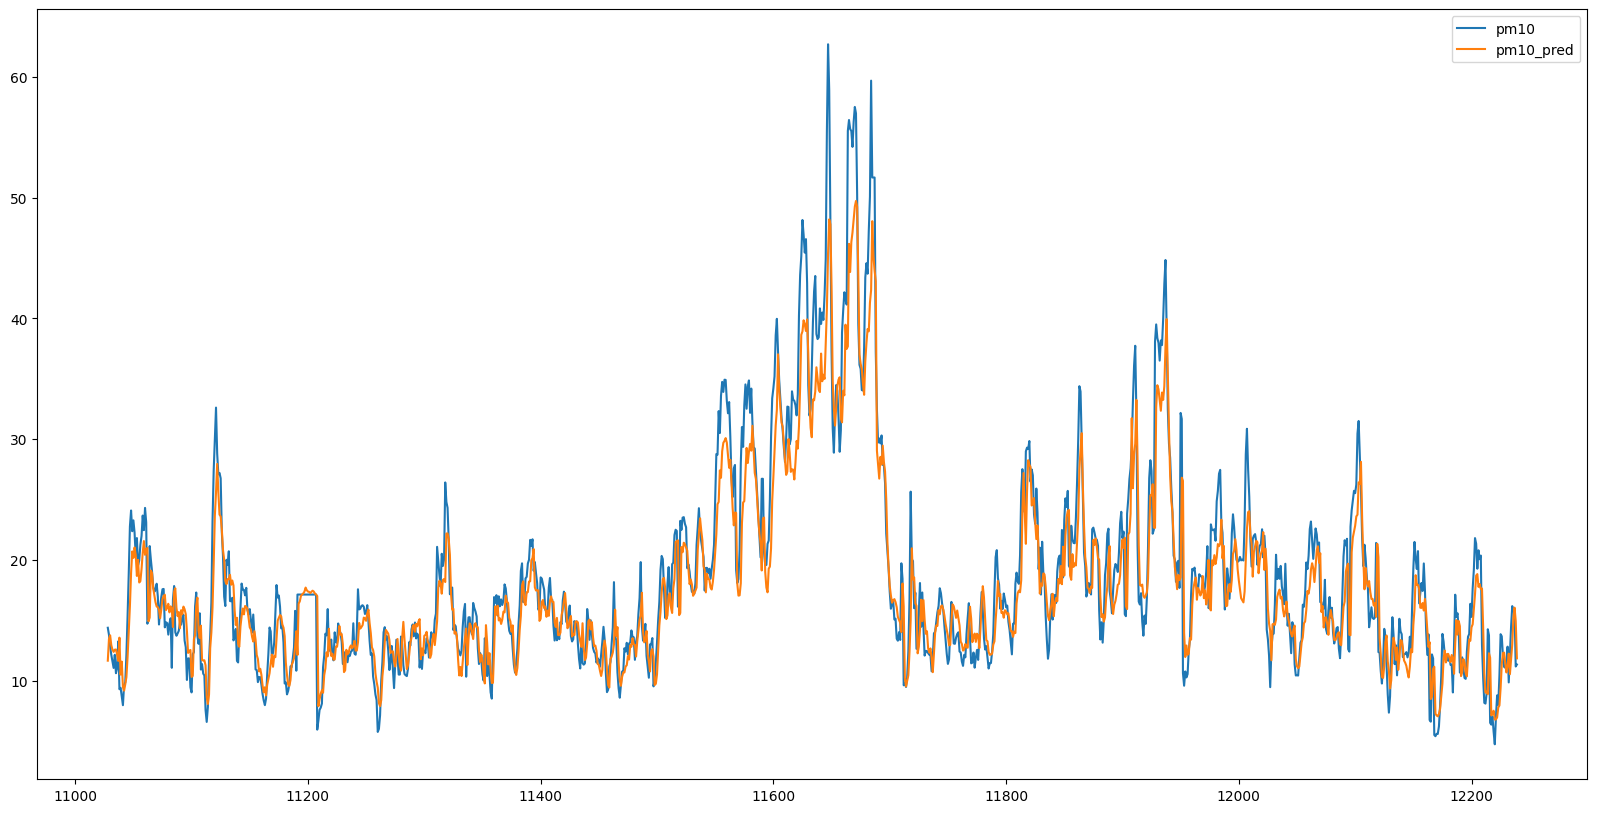

In [ ]:
df_final[["pm10","pm10_pred"]].plot(figsize=(20,10))

<Axes: >

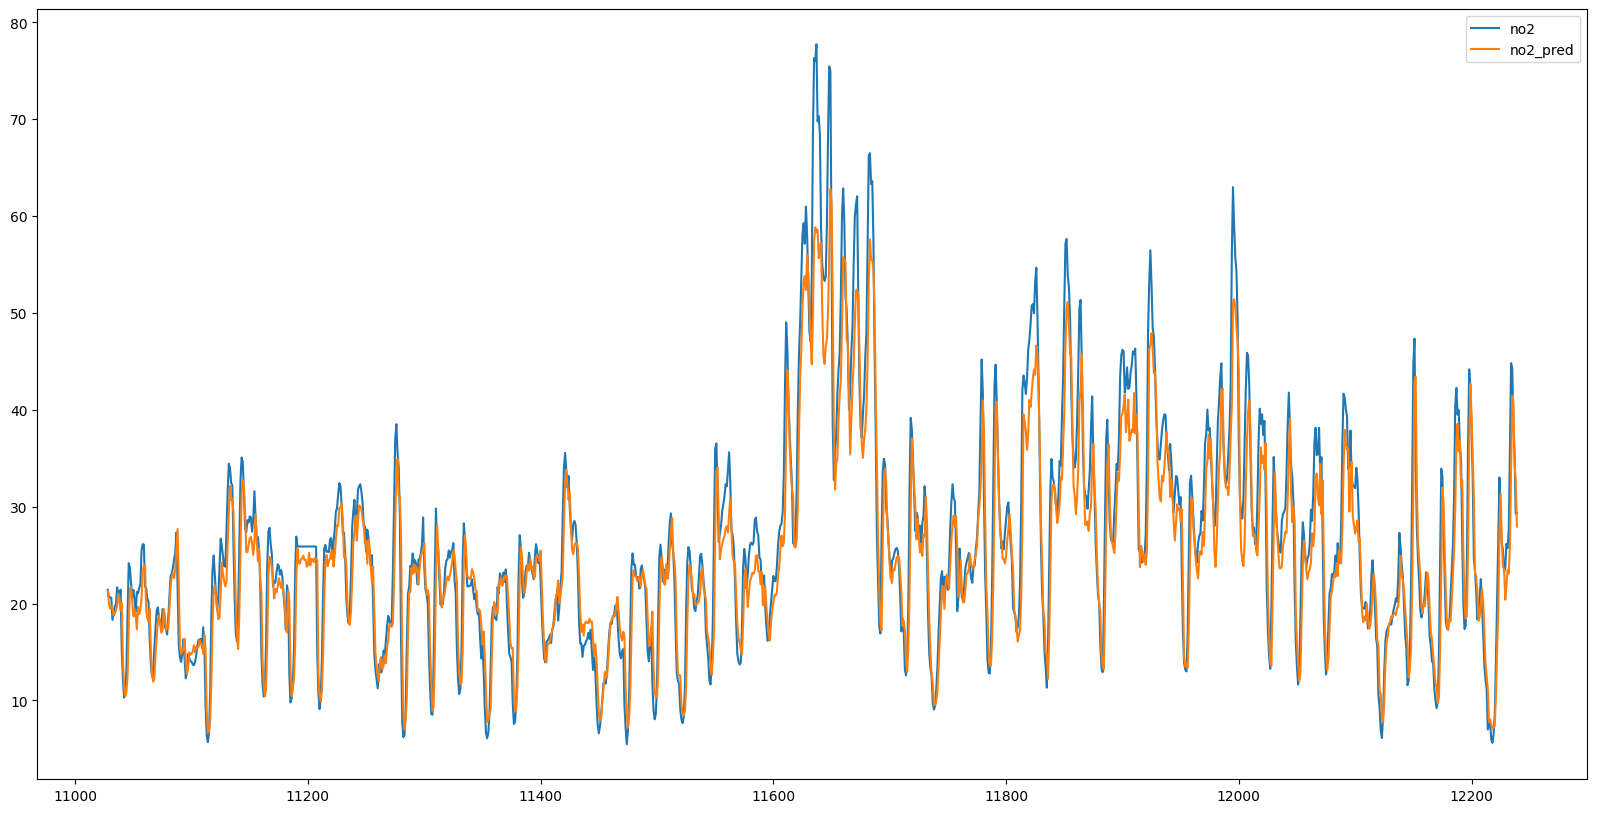

In [ ]:
df_final[["no2","no2_pred"]].plot(figsize=(20,10))

<Axes: >

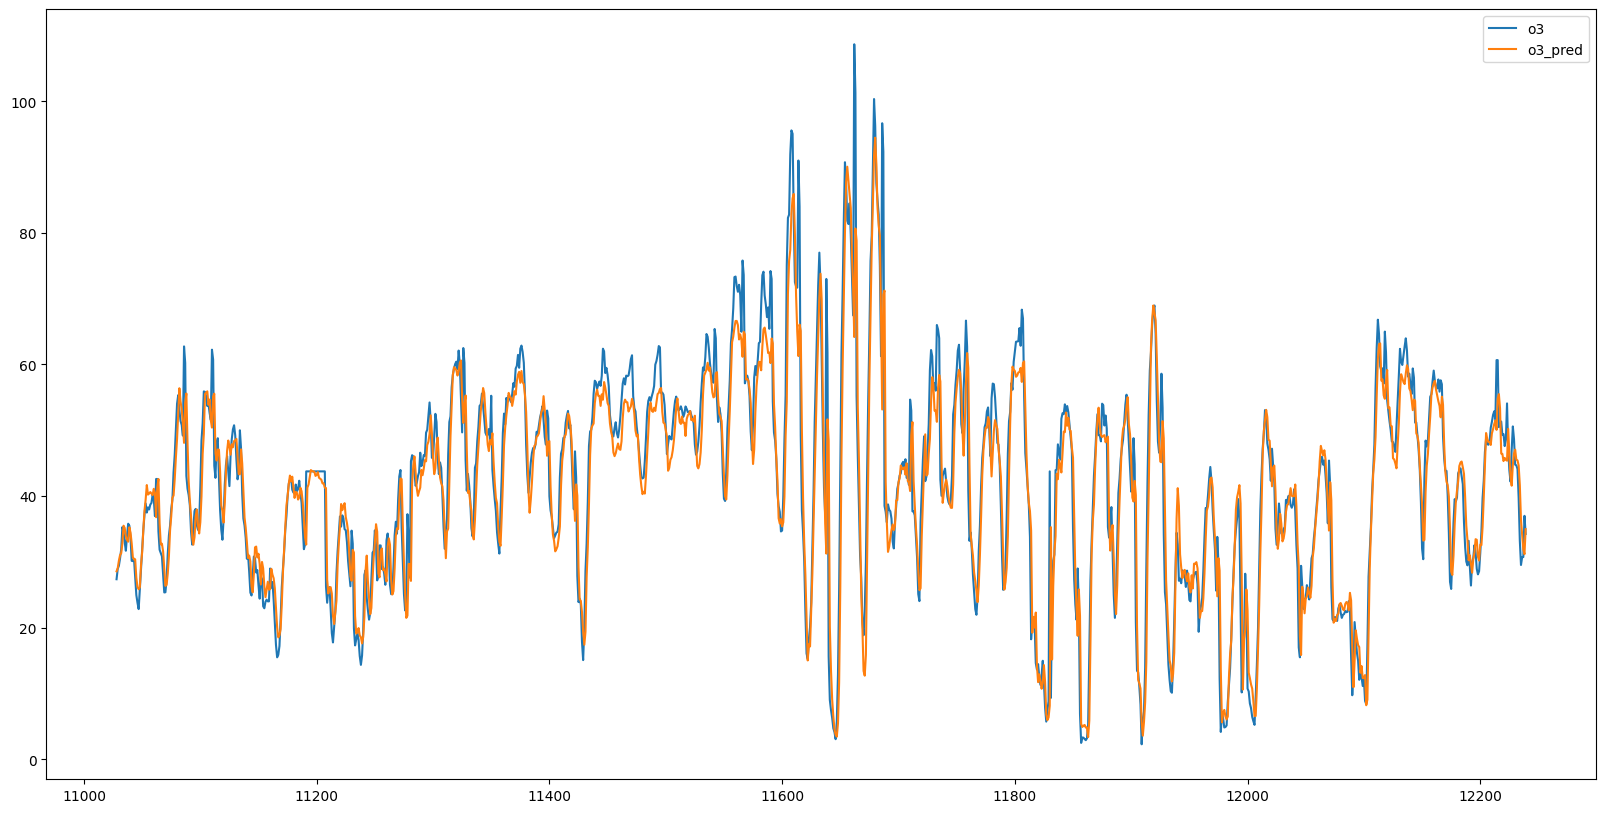

In [ ]:
df_final[["o3","o3_pred"]].plot(figsize=(20,10))

<Axes: >

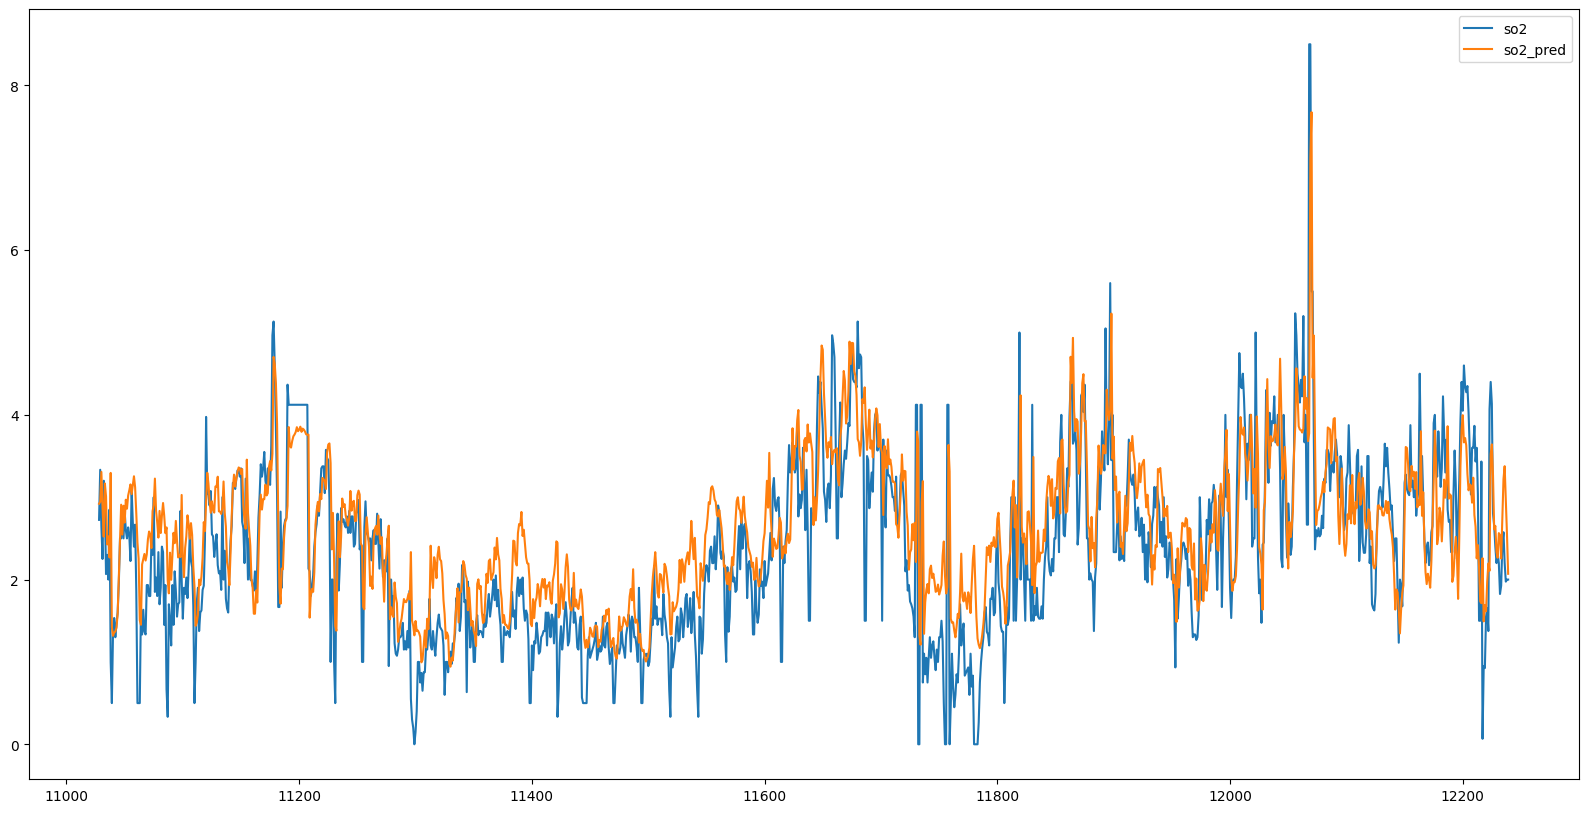

In [ ]:
df_final[["so2","so2_pred"]].plot(figsize=(20,10))

# Loss comparison of model

In [ ]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mslr = tf.keras.metrics.mean_squared_logarithmic_error(y_true, y_pred)
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mslr": mslr.numpy(),
           }

In [ ]:
selected_features = ["pm25", "pm10", "no2", "o3", "so2"]

for feature in selected_features:
    print("-----{}-----".format(feature))
    print(evaluate_preds(y_true=df_final[feature].values,
                         y_pred=df_final["{}_pred".format(feature)].values)
         )

-----pm25-----
{'mae': 1.2505535, 'mse': 4.950163, 'rmse': 2.2248962, 'mape': 13.905065, 'mslr': 0.02635186}
-----pm10-----
{'mae': 2.2331822, 'mse': 10.126775, 'rmse': 3.1822593, 'mape': 12.085637, 'mslr': 0.022194523}
-----no2-----
{'mae': 3.0318358, 'mse': 17.802387, 'rmse': 4.2192874, 'mape': 11.854589, 'mslr': 0.022914395}
-----o3-----
{'mae': 3.81852, 'mse': 33.584965, 'rmse': 5.7952533, 'mape': 11.703433, 'mslr': 0.030844308}
-----so2-----
{'mae': 0.55016965, 'mse': 0.52919877, 'rmse': 0.7274605, 'mape': 17112566.0, 'mslr': 0.060006447}


# 2. 1DCNN-BILSTM Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Activation,Conv1D, LSTM,Bidirectional,MaxPooling1D
from tensorflow.keras.optimizers import Adam


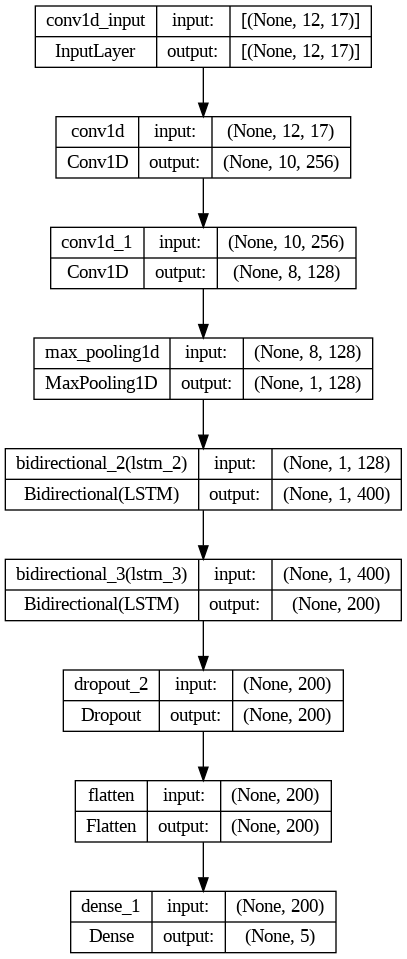

In [ ]:
model_CNN = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation="relu", input_shape=(win_length, num_features)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation="relu"),
     tf.keras.layers.MaxPooling1D(pool_size=5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(targets.shape[1],activation="softmax"),

])

model_CNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.losses.MeanSquaredLogarithmicError())

tf.keras.utils.plot_model(model=model_CNN, show_shapes=True)

In [ ]:
lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, cooldown=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

with tf.device('/GPU:0'):
    prepared_model = model_CNN.fit(train_generator, 
                                    validation_data=val_generator,
                                    epochs=30, 
                                    shuffle=False,  
                                    callbacks=[lr_monitor, early_stopping])

Epoch 1/30
2476/2476 [==============================] - 41s 12ms/step - loss: 0.2872 - val_loss: 0.1291 - lr: 0.0010
Epoch 2/30
2476/2476 [==============================] - 26s 11ms/step - loss: 0.2185 - val_loss: 0.1306 - lr: 0.0010
Epoch 3/30
2476/2476 [==============================] - 26s 11ms/step - loss: 0.2177 - val_loss: 0.1288 - lr: 0.0010
Epoch 4/30
2476/2476 [==============================] - 27s 11ms/step - loss: 0.2177 - val_loss: 0.1286 - lr: 0.0010
Epoch 5/30
2476/2476 [==============================] - 26s 11ms/step - loss: 0.2097 - val_loss: 0.1259 - lr: 0.0010
Epoch 6/30
2476/2476 [==============================] - 26s 11ms/step - loss: 0.1894 - val_loss: 0.1185 - lr: 0.0010
Epoch 7/30
2476/2476 [==============================] - 26s 11ms/step - loss: 0.1809 - val_loss: 0.1161 - lr: 0.0010
Epoch 8/30
2476/2476 [==============================] - 26s 11ms/step - loss: 0.1783 - val_loss: 0.1161 - lr: 0.0010
Epoch 9/30
2476/2476 [==============================] - 29s 12ms

# Training v/s Validation loss

Text(0, 0.5, 'msle score')

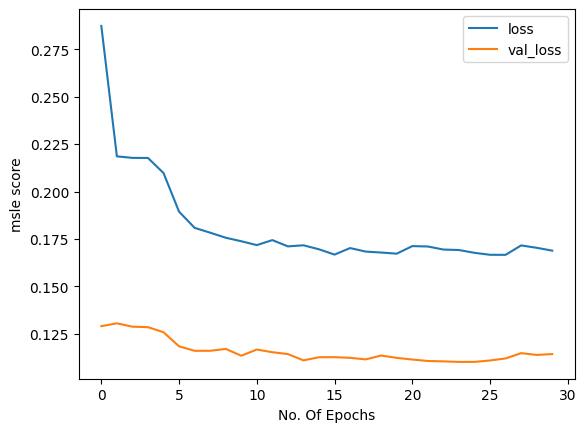

In [ ]:
plt.plot(prepared_model.history["loss"],label="loss")
plt.plot(prepared_model.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("msle score")

In [ ]:
model_CNN.evaluate(test_generator, verbose=1)

303/303 [==============================] - 1s 4ms/step - loss: 0.1583


0.15829958021640778

In [ ]:
predictions=model_CNN.predict(test_generator)

303/303 [==============================] - 3s 4ms/step


In [ ]:
df_pred=pd.DataFrame(X_test[:,:][win_length:])

rev_trans=scaler.inverse_transform(df_pred)

df_final_cnn=dataset[rev_trans.shape[0]*-1:]
df_final_cnn

,pm25,pm10,no2,o3,so2,co,temp,rhum,wspd,pres,coco,pm25_AQI,pm10_AQI,no2_AQI,o3_AQI,so2_AQI,overall_AQI
11028,6.330435,14.375439,21.420000,27.362499,2.725000,500.000000,21.0,73.0,18.4,1018.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0
11029,6.617391,13.792982,20.632500,28.937500,3.333333,450.000000,21.0,73.0,20.5,1018.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0
11030,5.734783,12.836843,20.650000,29.412500,2.650000,450.000000,22.0,65.0,20.5,1018.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0
11031,5.813044,12.135715,20.601250,30.531250,2.250000,500.000000,21.0,69.0,20.5,1018.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0
11032,5.756522,11.617857,18.305063,31.906250,3.200000,500.000000,21.0,69.0,14.8,1018.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12235,7.930435,16.167856,44.270885,29.529411,2.575000,450.000000,13.0,63.0,13.0,1012.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0
12236,7.986957,15.759259,38.663635,30.725000,2.200000,400.000000,12.0,67.0,14.8,1012.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
12237,6.166667,15.637837,35.358334,30.737499,1.975000,350.000000,11.0,71.0,9.4,1012.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
12238,4.000000,11.166667,29.250000,37.000000,2.000000,359.293549,11.0,71.0,7.6,1012.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
df_final_cnn[["pm25_pred", "pm10_pred", "no2_pred", "o3_pred", "so2_pred"]]=predictions
df_final_cnn

<ipython-input-45-771d601f361b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_cnn[["pm25_pred", "pm10_pred", "no2_pred", "o3_pred", "so2_pred"]]=predictions
<ipython-input-45-771d601f361b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_cnn[["pm25_pred", "pm10_pred", "no2_pred", "o3_pred", "so2_pred"]]=predictions
<ipython-input-45-771d601f361b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

,pm25,pm10,no2,o3,so2,co,temp,rhum,wspd,pres,...,pm10_AQI,no2_AQI,o3_AQI,so2_AQI,overall_AQI,pm25_pred,pm10_pred,no2_pred,o3_pred,so2_pred
11028,6.330435,14.375439,21.420000,27.362499,2.725000,500.000000,21.0,73.0,18.4,1018.0,...,1.0,1.0,1.0,1.0,1.0,7.836601,15.029091,22.734249,43.415783,3.098632
11029,6.617391,13.792982,20.632500,28.937500,3.333333,450.000000,21.0,73.0,20.5,1018.0,...,1.0,1.0,1.0,1.0,1.0,7.684483,14.770984,22.344019,43.488171,3.070210
11030,5.734783,12.836843,20.650000,29.412500,2.650000,450.000000,22.0,65.0,20.5,1018.0,...,1.0,1.0,1.0,1.0,1.0,7.663916,14.735846,22.290798,43.497513,3.066340
11031,5.813044,12.135715,20.601250,30.531250,2.250000,500.000000,21.0,69.0,20.5,1018.0,...,1.0,1.0,1.0,1.0,1.0,7.653673,14.718295,22.264135,43.502048,3.064433
11032,5.756522,11.617857,18.305063,31.906250,3.200000,500.000000,21.0,69.0,14.8,1018.0,...,1.0,1.0,1.0,1.0,1.0,7.649372,14.710965,22.253094,43.504040,3.063604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12235,7.930435,16.167856,44.270885,29.529411,2.575000,450.000000,13.0,63.0,13.0,1012.0,...,1.0,2.0,1.0,1.0,2.0,6.444577,12.567336,19.106598,43.913811,2.777655
12236,7.986957,15.759259,38.663635,30.725000,2.200000,400.000000,12.0,67.0,14.8,1012.0,...,1.0,1.0,1.0,1.0,1.0,6.463306,12.606763,19.161705,43.900703,2.783028
12237,6.166667,15.637837,35.358334,30.737499,1.975000,350.000000,11.0,71.0,9.4,1012.0,...,1.0,1.0,1.0,1.0,1.0,7.347064,14.182336,21.456135,43.622898,3.000180
12238,4.000000,11.166667,29.250000,37.000000,2.000000,359.293549,11.0,71.0,7.6,1012.0,...,1.0,1.0,1.0,1.0,1.0,8.173183,15.598852,23.595940,43.216484,3.153141


In [ ]:
def calcPM25(x):
    if x <= 10:
        return 1
    elif x >=11 and x <= 20:
        return 2
    elif x >=21 and x <= 25:
        return 3
    elif x >=26 and x <= 50:
        return 4
    elif x >=51 and x <= 75:
        return 5
    elif x >=76:
        return 6
    else:
        return 1
    
def calcPM10(x):
    if x <= 20:
        return 1
    elif x >=21 and x <= 40:
        return 2
    elif x >=41 and x <= 50:
        return 3
    elif x >=51 and x <= 100:
        return 4
    elif x >=101 and x <= 150:
        return 5
    elif x >=151:
        return 6
    else:
        return 1
    
def calcNO2(x):
    if x <= 40:
        return 1
    elif x >=41 and x <= 90:
        return 2
    elif x >=91 and x <= 120:
        return 3
    elif x >=121 and x <= 230:
        return 4
    elif x >=231 and x <= 340:
        return 5
    elif x >=341:
        return 6
    else:
        return 1
    
def calcO3(x):
    if x <= 50:
        return 1
    elif x >=51 and x <= 100:
        return 2
    elif x >=101 and x <= 130:
        return 3
    elif x >=131 and x <= 240:
        return 4
    elif x >=241 and x <= 380:
        return 5
    elif x >=381:
        return 6
    else:
        return 1
    
def calcSO2(x):
    if x <= 100:
        return 1
    elif x >=101 and x <= 200:
        return 2
    elif x >=201 and x <= 350:
        return 3
    elif x >=351 and x <= 500:
        return 4
    elif x >=501 and x <= 750:
        return 5
    elif x >=751:
        return 6
    else:
        return 1
    

    
df_final_cnn["pm25_AQI_pred"] = df_final_cnn["pm25_pred"].apply(lambda x: calcPM25(x))
df_final_cnn["pm10_AQI_pred"] = df_final_cnn["pm10_pred"].apply(lambda x: calcPM10(x))
df_final_cnn["no2_AQI_pred"] = df_final_cnn["no2_pred"].apply(lambda x: calcNO2(x))
df_final_cnn["o3_AQI_pred"] = df_final_cnn["o3_pred"].apply(lambda x: calcO3(x))
df_final_cnn["so2_AQI_pred"] = df_final_cnn["so2_pred"].apply(lambda x: calcSO2(x))

<ipython-input-46-a3d8f0059fa7>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_cnn["pm25_AQI_pred"] = df_final_cnn["pm25_pred"].apply(lambda x: calcPM25(x))
<ipython-input-46-a3d8f0059fa7>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_cnn["pm10_AQI_pred"] = df_final_cnn["pm10_pred"].apply(lambda x: calcPM10(x))
<ipython-input-46-a3d8f0059fa7>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [ ]:
df_final_cnn["overall_pred_aqi"] = df_final_cnn[["pm25_AQI_pred","pm10_AQI_pred","no2_AQI_pred","o3_AQI_pred","so2_AQI_pred"]].max(axis=1)

df_final_cnn

<ipython-input-47-b190dd974fe2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_cnn["overall_pred_aqi"] = df_final_cnn[["pm25_AQI_pred","pm10_AQI_pred","no2_AQI_pred","o3_AQI_pred","so2_AQI_pred"]].max(axis=1)


,pm25,pm10,no2,o3,so2,co,temp,rhum,wspd,pres,...,pm10_pred,no2_pred,o3_pred,so2_pred,pm25_AQI_pred,pm10_AQI_pred,no2_AQI_pred,o3_AQI_pred,so2_AQI_pred,overall_pred_aqi
11028,6.330435,14.375439,21.420000,27.362499,2.725000,500.000000,21.0,73.0,18.4,1018.0,...,15.029091,22.734249,43.415783,3.098632,1,1,1,1,1,1
11029,6.617391,13.792982,20.632500,28.937500,3.333333,450.000000,21.0,73.0,20.5,1018.0,...,14.770984,22.344019,43.488171,3.070210,1,1,1,1,1,1
11030,5.734783,12.836843,20.650000,29.412500,2.650000,450.000000,22.0,65.0,20.5,1018.0,...,14.735846,22.290798,43.497513,3.066340,1,1,1,1,1,1
11031,5.813044,12.135715,20.601250,30.531250,2.250000,500.000000,21.0,69.0,20.5,1018.0,...,14.718295,22.264135,43.502048,3.064433,1,1,1,1,1,1
11032,5.756522,11.617857,18.305063,31.906250,3.200000,500.000000,21.0,69.0,14.8,1018.0,...,14.710965,22.253094,43.504040,3.063604,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12235,7.930435,16.167856,44.270885,29.529411,2.575000,450.000000,13.0,63.0,13.0,1012.0,...,12.567336,19.106598,43.913811,2.777655,1,1,1,1,1,1
12236,7.986957,15.759259,38.663635,30.725000,2.200000,400.000000,12.0,67.0,14.8,1012.0,...,12.606763,19.161705,43.900703,2.783028,1,1,1,1,1,1
12237,6.166667,15.637837,35.358334,30.737499,1.975000,350.000000,11.0,71.0,9.4,1012.0,...,14.182336,21.456135,43.622898,3.000180,1,1,1,1,1,1
12238,4.000000,11.166667,29.250000,37.000000,2.000000,359.293549,11.0,71.0,7.6,1012.0,...,15.598852,23.595940,43.216484,3.153141,1,1,1,1,1,1


# Accuracy Prediction

In [ ]:
from sklearn.metrics import accuracy_score

overall_AQI = df_final_cnn["overall_AQI"].values
overall_pred_aqi = df_final_cnn["overall_pred_aqi"].values

accuracy = accuracy_score(overall_AQI, overall_pred_aqi)

print(accuracy)

0.5618811881188119


# Visualization of actual and predicted values by model

<Axes: >

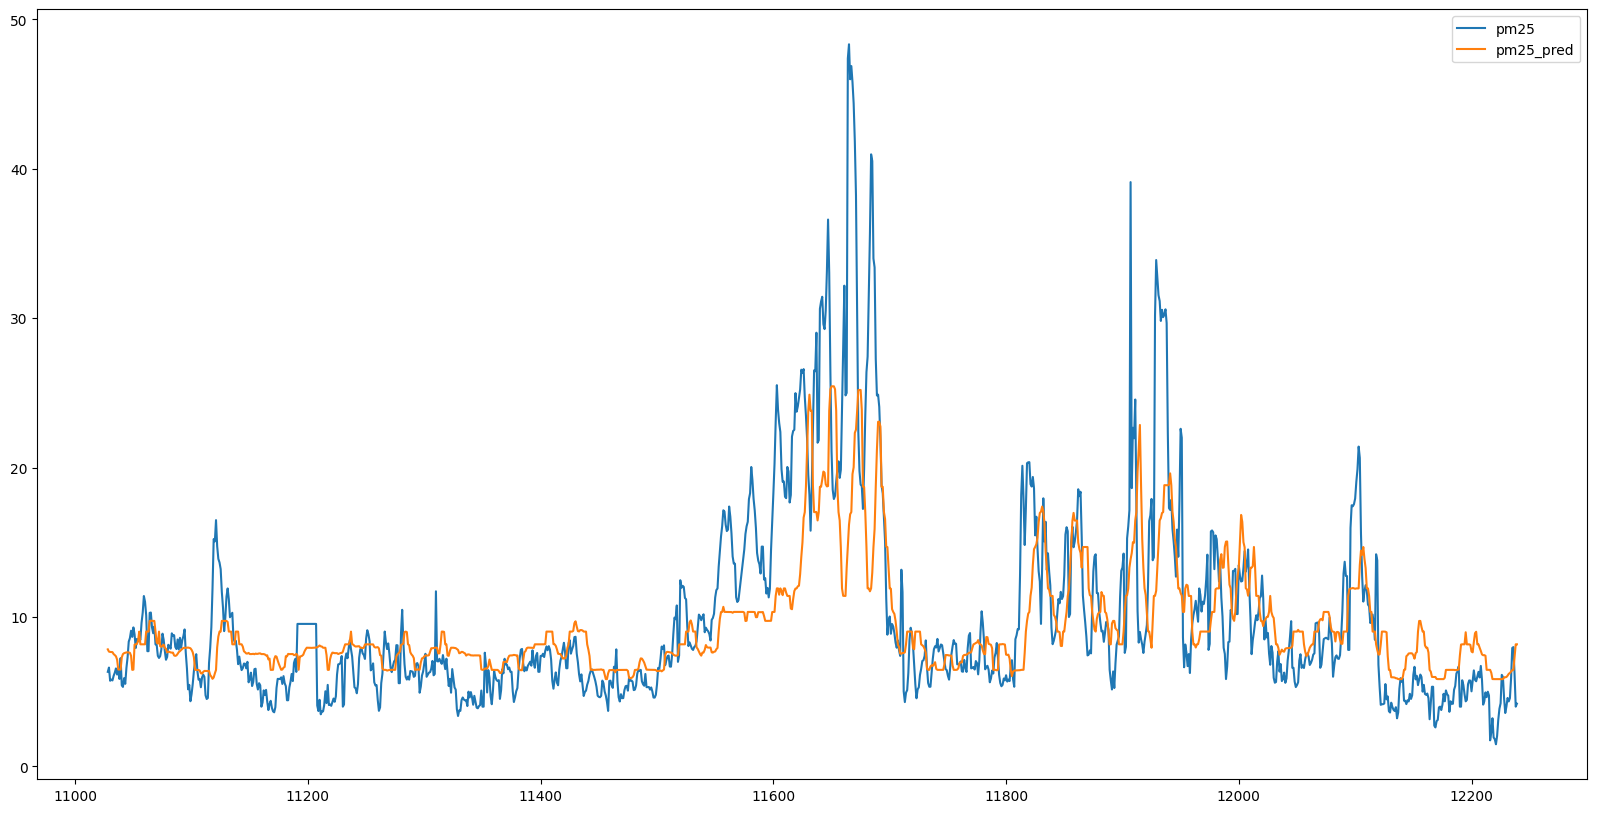

In [ ]:
df_final_cnn[["pm25","pm25_pred"]].plot(figsize=(20,10))

<Axes: >

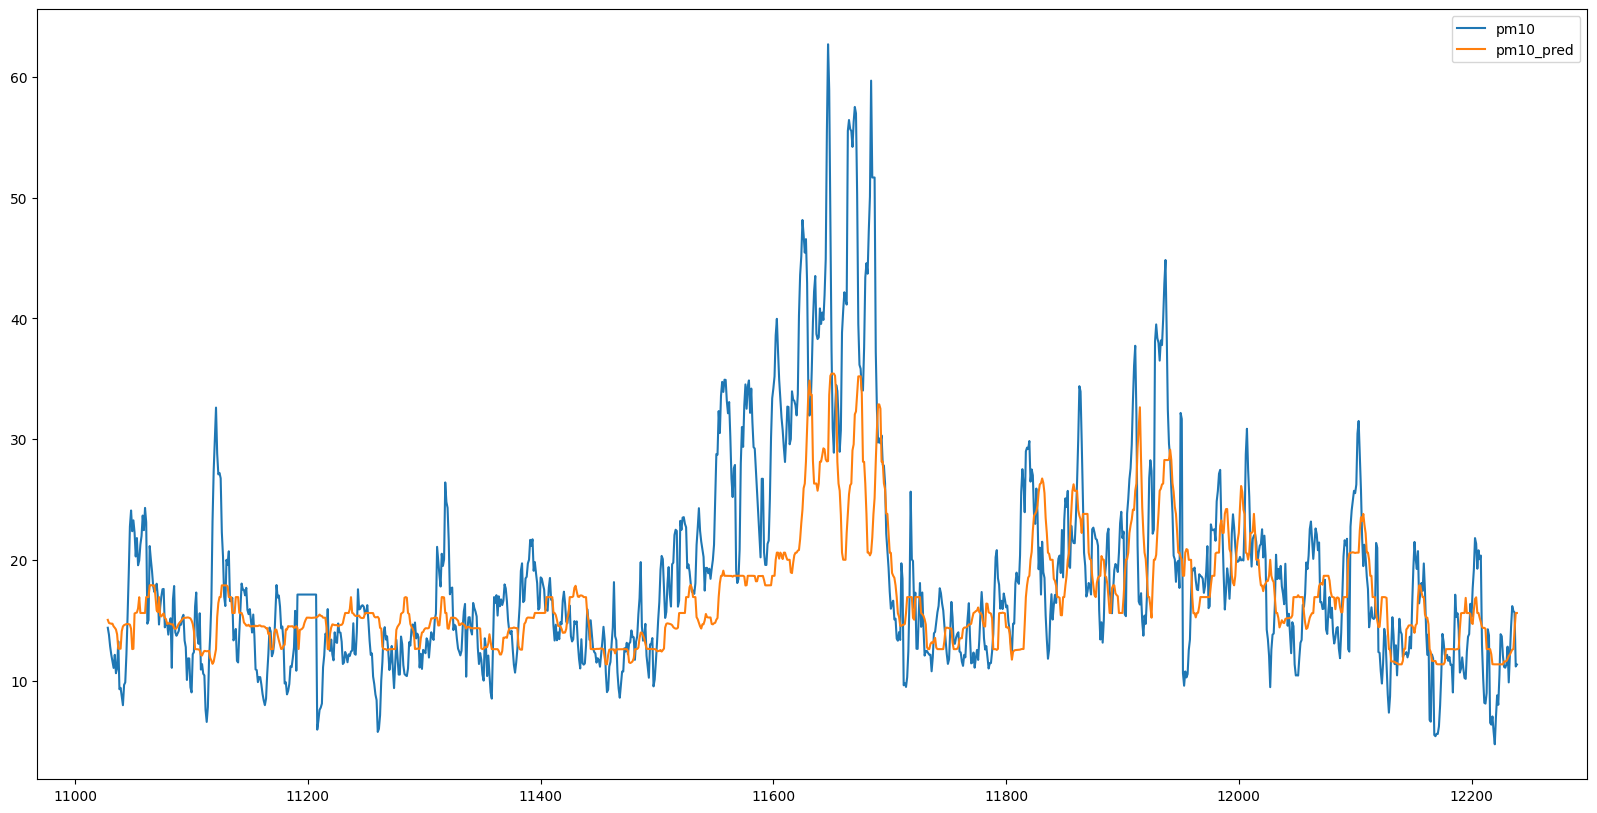

In [ ]:
df_final_cnn[["pm10","pm10_pred"]].plot(figsize=(20,10))

<Axes: >

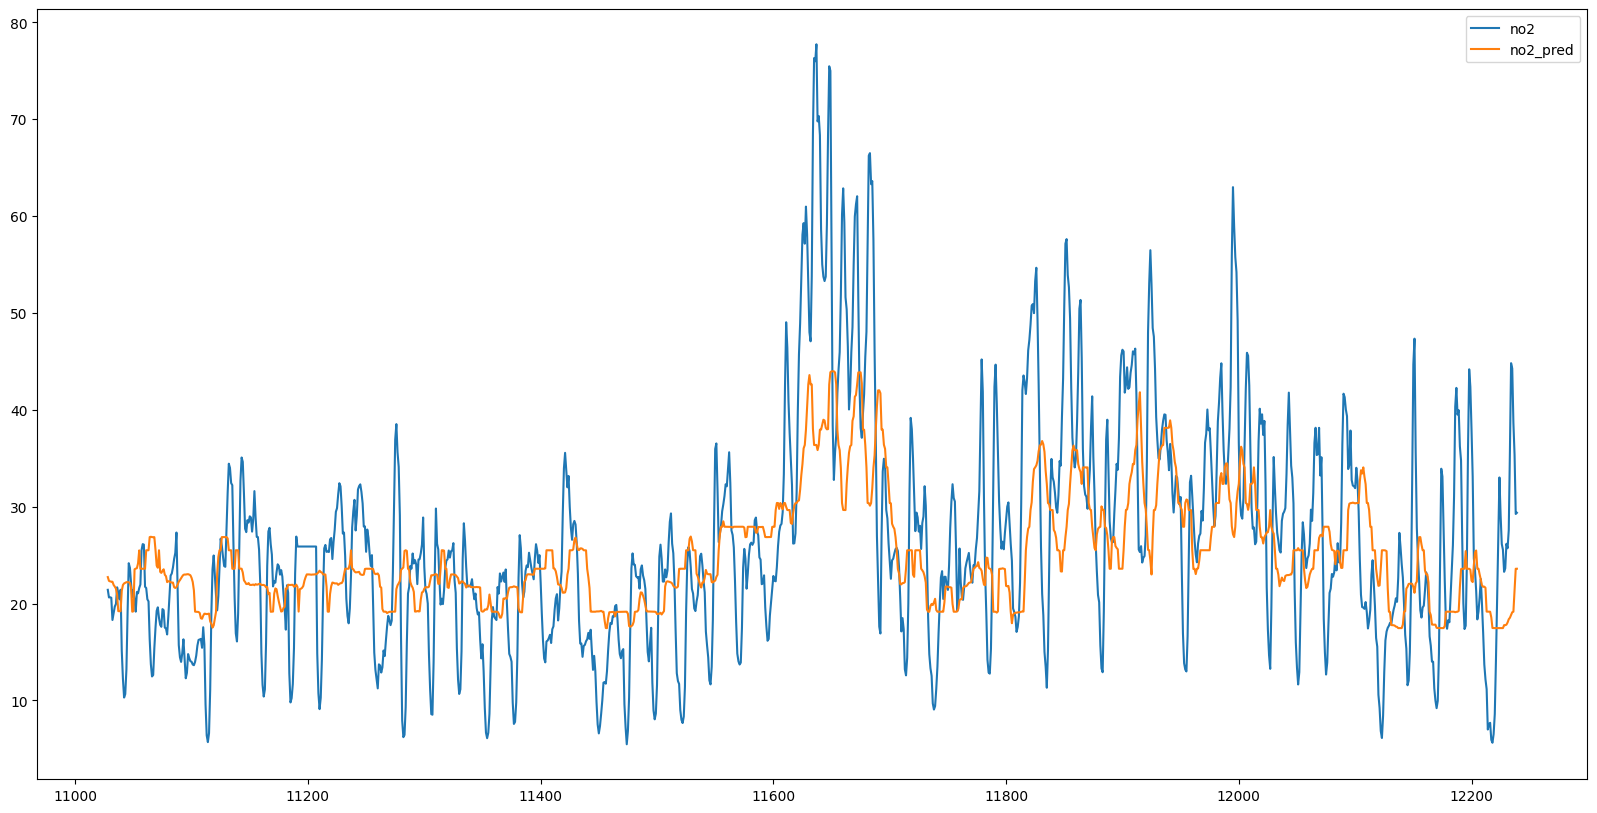

In [ ]:
df_final_cnn[["no2","no2_pred"]].plot(figsize=(20,10))

<Axes: >

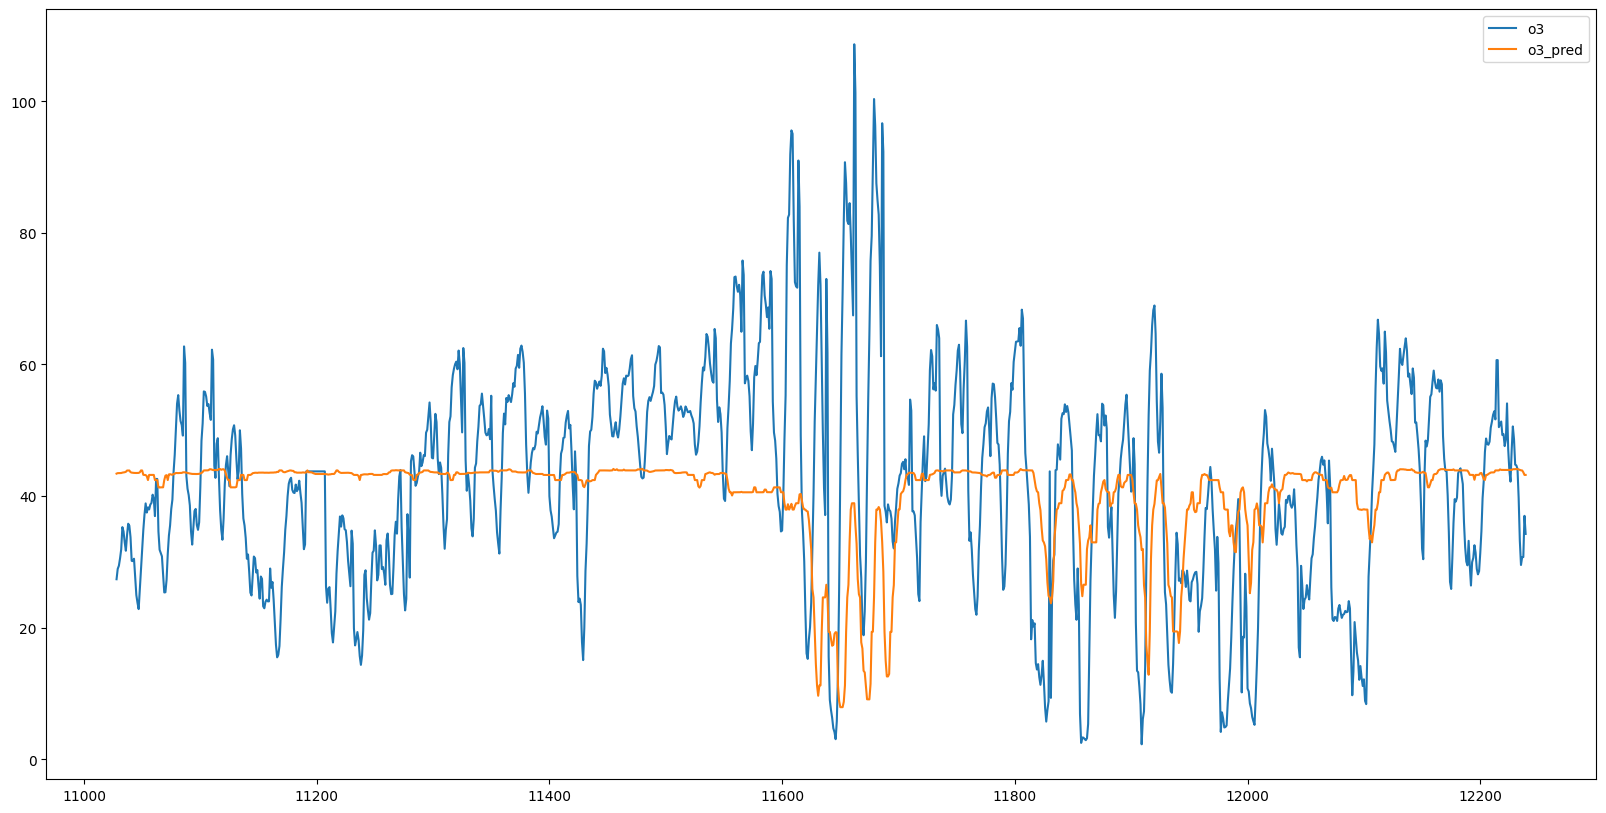

In [ ]:
df_final_cnn[["o3","o3_pred"]].plot(figsize=(20,10))

<Axes: >

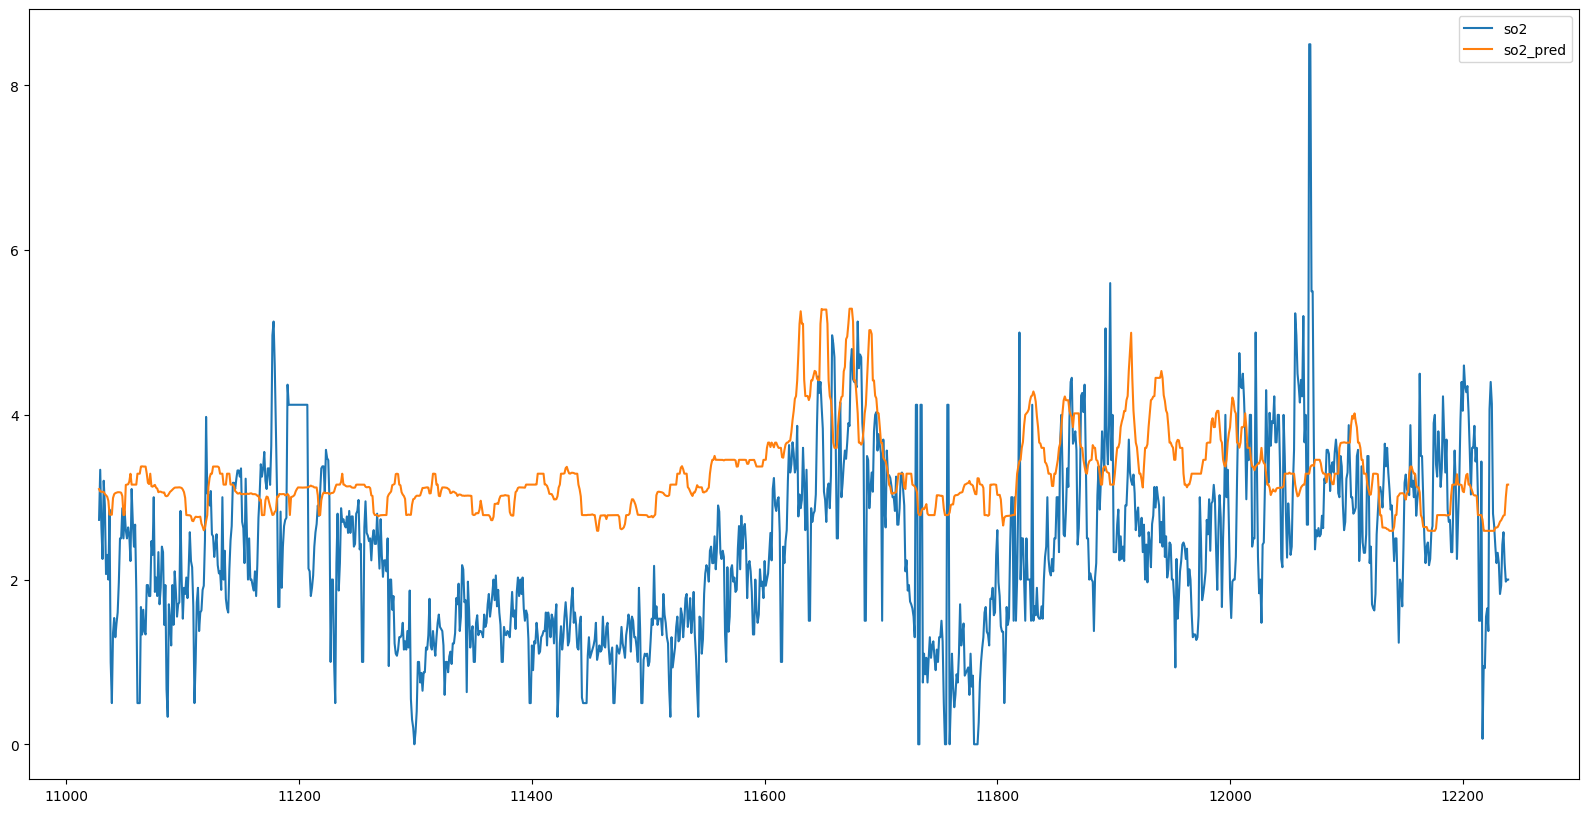

In [ ]:
df_final_cnn[["so2","so2_pred"]].plot(figsize=(20,10))

# Losses comparison of model

In [ ]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mslr = tf.keras.metrics.mean_squared_logarithmic_error(y_true, y_pred)
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mslr": mslr.numpy(),
           }

In [ ]:
selected_features = ["pm25", "pm10", "no2", "o3", "so2"]

for feature in selected_features:
    print("-----{}-----".format(feature))
    print(evaluate_preds(y_true=df_final_cnn[feature].values,
                         y_pred=df_final_cnn["{}_pred".format(feature)].values)
         )

-----pm25-----
{'mae': 3.0354881, 'mse': 23.958544, 'rmse': 4.8947463, 'mape': 31.712004, 'mslr': 0.11032583}
-----pm10-----
{'mae': 4.597346, 'mse': 46.466152, 'rmse': 6.8166084, 'mape': 23.837444, 'mslr': 0.084565766}
-----no2-----
{'mae': 7.3994913, 'mse': 99.00996, 'rmse': 9.950375, 'mape': 33.871727, 'mslr': 0.13816334}
-----o3-----
{'mae': 13.065162, 'mse': 299.52457, 'rmse': 17.306778, 'mape': 49.61627, 'mslr': 0.27008}
-----so2-----
{'mae': 1.1940129, 'mse': 1.924131, 'rmse': 1.3871305, 'mape': 24209730.0, 'mslr': 0.18836303}
